<a href="https://colab.research.google.com/github/AleksandrMac/learning/blob/main/ai/hw/14.3%20%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

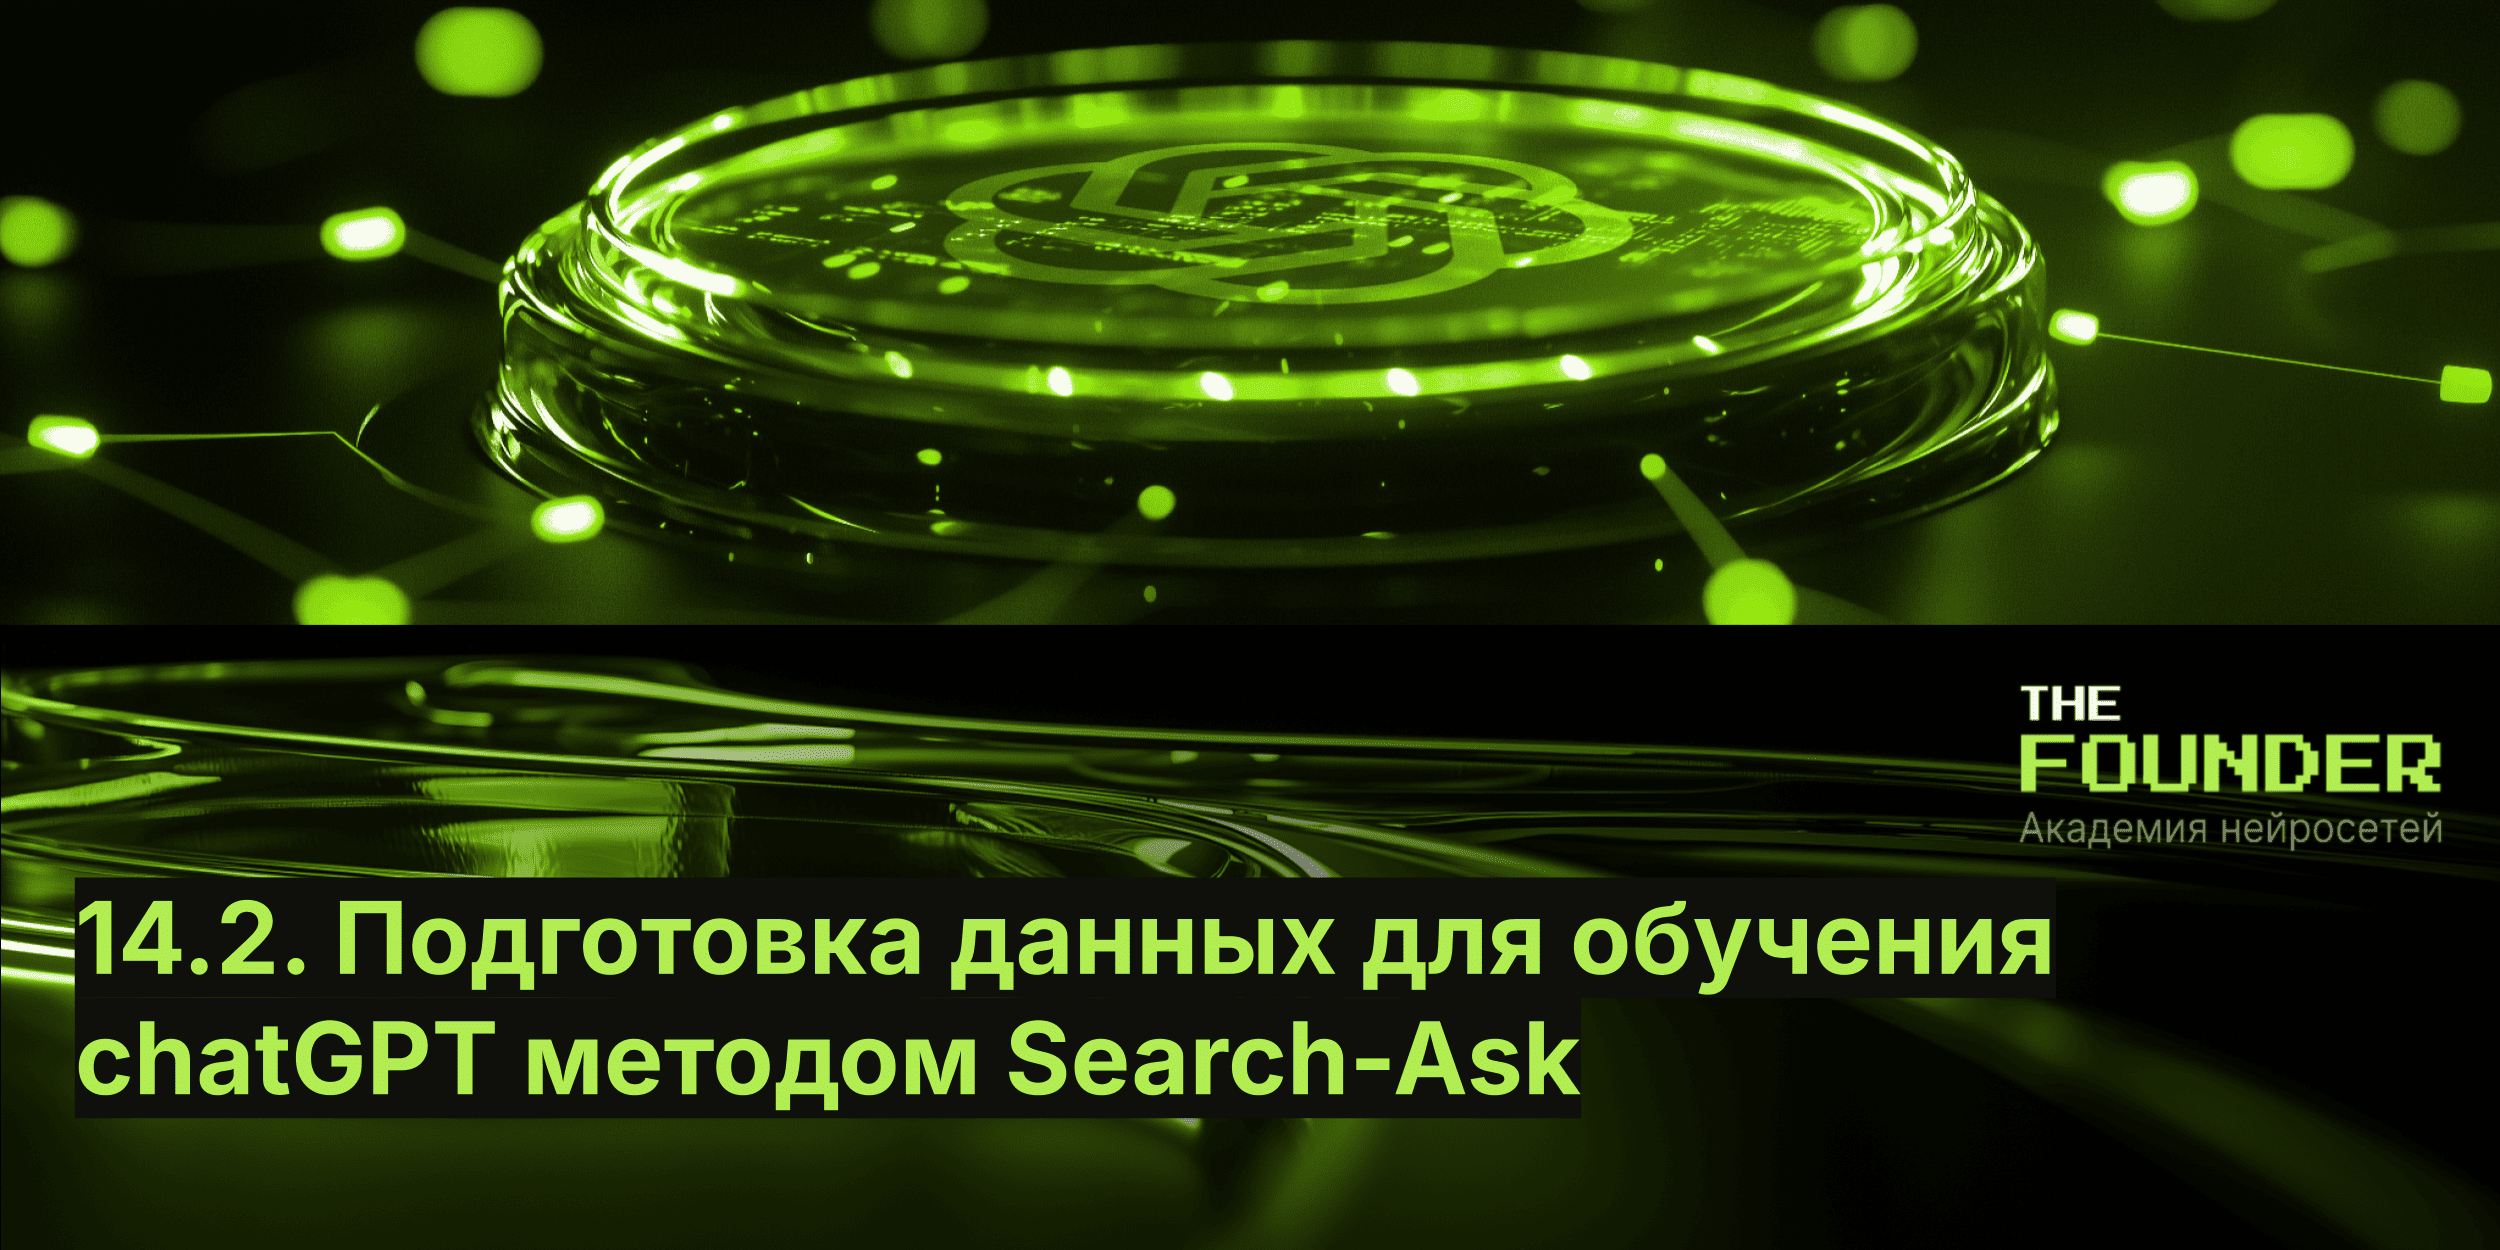

**Навигация по уроку**

1. [Telegram бот c ChatGPT на борту. Знакомство с  ChatGPT](https://colab.research.google.com/drive/1tqXt0XNstMb2TeJ8Za9S2xQA6ipjyMPk)
2. Подготовка данных для обучения chatGPT методом Search-Ask (Практика)
3. [Домашняя работа](https://colab.research.google.com/drive/13zTaGNA9cr9SjaYFzpDPp-72i8SQFqrp)

Перед вами практическая часть урока. Проанализируйте данный Блокнот и попробуйте самостоятельно сформировать базу знаний (файл `csv`) по интересующей вас теме. В домашней работе, вы будете использовать ваш файл базы знаний, чтобы создать телеграм-бот, который отвечает на вопросы по вашей базе знаний. Мы настоятельно рекомендуем ознакомиться с [домашним заданием](https://colab.research.google.com/drive/13zTaGNA9cr9SjaYFzpDPp-72i8SQFqrp) перед выбором тематики для вашей базы знаний. Ваша база знаний может быть как результатом парсинга Википедии, так и любого другого ресурса, включая выгрузку из мессенджеров, zoom-конференций, нормативной базы компании.

Итак вспомним алгоритм Search-Ask, а точнее его первый пункт о подготовке поисковых данных:
* Сбор: загружаем документы;
* Фрагментация: документы разбиваются на короткие, в основном автономные разделы для токенизации;
* Токенизация или вычисление эмбендингов: каждый раздел преобразуется в последовательность токенов с помощью OpenAI API;
* Хранилище: последовательности токенов сохраняются.


## Сбор данных и фрагментация

Для сбора и подготовки данных нам необходимо:
* Собрать все заголовки статей заданной категории статей Википедии, заходя на первый уровень вложенности статей.
* Разделить каждую статью на разделы (секции) и подразделы. Отбросить менее релевантные разделы, такие как внешние ссылки и сноски.
* Очистить текст, удалив теги ссылок, пробелы и очень короткие секции (разделы).
* Добавить заголовки и подзаголовки к тексту каждого раздела, чтобы помочь chatGPT понять контекст.

### Сбор заголовков статей из категории

In [ ]:
# Отключим предупреждения в колабе. Будет меньше лишней информации в выводе
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install openai mwclient mwparserfromhell tiktoken

In [ ]:
# imports
import mwclient  # библиотека для работы с MediaWiki API для загрузки примеров статей Википедии
import mwparserfromhell  # Парсер для MediaWiki
import openai  # будем использовать для токинизации
import pandas as pd  # В DataFrame будем хранить базу знаний и результат токинизации базы знаний
import re  # для вырезания ссылок <ref> из статей Википедии
import tiktoken  # для подсчета токенов

In [ ]:
# поиск страниц Википедии о зимних Олимпийских играх 2022 года

# Задаем категорию и англоязычную версию Википедии для поиска
CATEGORY_TITLE = "Category:2022 Winter Olympics"
WIKI_SITE = "en.wikipedia.org"

# Соберем заголовки всех статей
def titles_from_category(
    category: mwclient.listing.Category, # Задаем типизированный параметр категории статей
    max_depth: int # Определяем глубину вложения статей
) -> set[str]:
    """Возвращает набор заголовков страниц в данной категории Википедии и ее подкатегориях."""
    titles = set() # Используем множество для хранения заголовков статей
    for cm in category.members(): # Перебираем вложенные объекты категории
        if type(cm) == mwclient.page.Page: # Если объект является страницей
            titles.add(cm.name) # в хранилище заголовков добавляем имя страницы
        elif isinstance(cm, mwclient.listing.Category) and max_depth > 0: # Если объект является категорией и глубина вложения не достигла максимальной
            deeper_titles = titles_from_category(cm, max_depth=max_depth - 1) # вызываем рекурсивно функцию для подкатегории
            titles.update(deeper_titles) # добавление в множество элементов из другого множества
    return titles

# Инициализация объекта MediaWiki
# WIKI_SITE ссылается на англоязычную часть Википедии
site = mwclient.Site(WIKI_SITE)

# Загрузка раздела заданной категории
category_page = site.pages[CATEGORY_TITLE]
# Получение множества всех заголовков категории с вложенностью на один уровень
titles = titles_from_category(category_page, max_depth=1)


print(f"Создано {len(titles)} заголовков статей в категории {CATEGORY_TITLE}.")

Создано 732 заголовков статей в категории Category:2022 Winter Olympics.


### Извлечение секций из документов

Определим секции в документах, которые менее релевантны и их можно отбросить:



In [ ]:
# Задаем секции, которые будут отброшены при парсинге статей
SECTIONS_TO_IGNORE = [
    "See also",
    "References",
    "External links",
    "Further reading",
    "Footnotes",
    "Bibliography",
    "Sources",
    "Citations",
    "Literature",
    "Footnotes",
    "Notes and references",
    "Photo gallery",
    "Works cited",
    "Photos",
    "Gallery",
    "Notes",
    "References and sources",
    "References and notes",
]


In [ ]:
# Функция возвращает список всех вложенных секций для заданной секции страницы Википедии

def all_subsections_from_section(
    section: mwparserfromhell.wikicode.Wikicode, # текущая секция
    parent_titles: list[str], # Заголовки родителя
    sections_to_ignore: set[str], # Секции, которые необходимо проигнорировать
) -> list[tuple[list[str], str]]:
    """
    Из раздела Википедии возвращает список всех вложенных секций.
    Каждый подраздел представляет собой кортеж, где:
      - первый элемент представляет собой список родительских секций, начиная с заголовка страницы
      - второй элемент представляет собой текст секции
    """

    # Извлекаем заголовки текущей секции
    headings = [str(h) for h in section.filter_headings()]
    title = headings[0]
    # Заголовки Википедии имеют вид: "== Heading =="

    if title.strip("=" + " ") in sections_to_ignore:
        # Если заголовок секции в списке для игнора, то пропускаем его
        return []

    # Объединим заголовки и подзаголовки, чтобы сохранить контекст для chatGPT
    titles = parent_titles + [title]

    # Преобразуем wikicode секции в строку
    full_text = str(section)

    # Выделяем текст секции без заголовка
    section_text = full_text.split(title)[1]
    if len(headings) == 1:
        # Если один заголовок, то формируем результирующий список
        return [(titles, section_text)]
    else:
        first_subtitle = headings[1]
        section_text = section_text.split(first_subtitle)[0]
        # Формируем результирующий список из текста до первого подзаголовка
        results = [(titles, section_text)]
        for subsection in section.get_sections(levels=[len(titles) + 1]):
            results.extend(
                # Вызываем функцию получения вложенных секций для заданной секции
                all_subsections_from_section(subsection, titles, sections_to_ignore)
                )  # Объединяем результирующие списки данной функции и вызываемой
        return results

# Функция возвращает список всех секций страницы, за исключением тех, которые отбрасываем
def all_subsections_from_title(
    title: str, # Заголовок статьи Википедии, которую парсим
    sections_to_ignore: set[str] = SECTIONS_TO_IGNORE, # Секции, которые игнорируем
    site_name: str = WIKI_SITE, # Ссылка на сайт википедии
) -> list[tuple[list[str], str]]:
    """
    Из заголовка страницы Википедии возвращает список всех вложенных секций.
    Каждый подраздел представляет собой кортеж, где:
      - первый элемент представляет собой список родительских секций, начиная с заголовка страницы
      - второй элемент представляет собой текст секции
    """

    # Инициализация объекта MediaWiki
    # WIKI_SITE ссылается на англоязычную часть Википедии
    site = mwclient.Site(site_name)

    # Запрашиваем страницу по заголовку
    page = site.pages[title]

    # Получаем текстовое представление страницы
    text = page.text()

    # Удобный парсер для MediaWiki
    parsed_text = mwparserfromhell.parse(text)
    # Извлекаем заголовки
    headings = [str(h) for h in parsed_text.filter_headings()]
    if headings: # Если заголовки найдены
        # В качестве резюме берем текст до первого заголовка
        summary_text = str(parsed_text).split(headings[0])[0]
    else:
        # Если нет заголовков, то весь текст считаем резюме
        summary_text = str(parsed_text)
    results = [([title], summary_text)] # Добавляем резюме в результирующий список
    for subsection in parsed_text.get_sections(levels=[2]): # Извлекаем секции 2-го уровня
        results.extend(
            # Вызываем функцию получения вложенных секций для заданной секции
            all_subsections_from_section(subsection, [title], sections_to_ignore)
        ) # Объединяем результирующие списки данной функции и вызываемой
    return results

In [ ]:
# Разбивка статей на секции
# придется немного подождать, так как на парсинг 100 статей требуется около минуты
wikipedia_sections = []
for title in titles:
    wikipedia_sections.extend(all_subsections_from_title(title))
print(f"Найдено {len(wikipedia_sections)} секций на {len(titles)} страницах")

Найдено 5795 секций на 732 страницах


### Очистка текста (теги ссылок, пробелы и короткие секции)

In [ ]:
# Очистка текста секции от ссылок <ref>xyz</ref>, начальных и конечных пробелов
def clean_section(section: tuple[list[str], str]) -> tuple[list[str], str]:
    titles, text = section
    # Удаляем ссылки
    text = re.sub(r"<ref.*?</ref>", "", text)
    # Удаляем пробелы вначале и конце
    text = text.strip()
    return (titles, text)

# Применим функцию очистки ко всем секциям с помощью генератора списков
wikipedia_sections = [clean_section(ws) for ws in wikipedia_sections]

# Отфильтруем короткие и пустые секции
def keep_section(section: tuple[list[str], str]) -> bool:
    """Возвращает значение True, если раздел должен быть сохранен, в противном случае значение False."""
    titles, text = section
    # Фильтруем по произвольной длине, можно выбрать и другое значение
    if len(text) < 16:
        return False
    else:
        return True


original_num_sections = len(wikipedia_sections)
wikipedia_sections = [ws for ws in wikipedia_sections if keep_section(ws)]
print(f"Отфильтровано {original_num_sections-len(wikipedia_sections)} секций, осталось {len(wikipedia_sections)} секций.")


Отфильтровано 531 секций, осталось 5264 секций.


Для наглядности выведем 5 секций, заголовок и текст (50 первых символов) каждой секции

In [ ]:
for ws in wikipedia_sections[:5]:
    print(ws[0])
    display(ws[1][:50] + "...")
    print()

['Belgium at the 2022 Winter Olympics']


'{{Infobox country at games\n|NOC = BEL\n|NOCname = [...'


['Belgium at the 2022 Winter Olympics', '==Medalists==']


'{{further|2022 Winter Olympics medal table|List of...'


['Belgium at the 2022 Winter Olympics', '==Competitors==']


'The following is a list of the number of competito...'


['Belgium at the 2022 Winter Olympics', '==Alpine skiing==']


'{{main article|Alpine skiing at the 2022 Winter Ol...'


['Belgium at the 2022 Winter Olympics', '== Biathlon ==']


'{{Main|Biathlon at the 2022 Winter Olympics|Biathl...'

### Фрагментация документов

Поскольку chatGPT может одновременно считывать только ограниченный объем токенов, нам необходимо разделить каждый документ на фрагменты (части).

Далее мы рекурсивно разделим длинные разделы на более мелкие. Идеального рецепта разделения текста на разделы не существует.

Однако, можно сделать следующие предположения:

* Более длинные разделы могут быть лучше для вопросов, требующих большего контекста.
* Более длинные разделы могут быть хуже для поиска, поскольку в них может быть больше запутанных тем.
* Более короткие разделы лучше подходят для снижения затрат, которые пропорциональны количеству токенов.
* Более короткие разделы позволяют извлекать больше разделов для запроса, что может помочь с полнотой данных.
* Перекрывающиеся разделы могут помочь предотвратить обрезание ответов по смыслу границами разделов.

Учитывая все выше сказанное, мы будем использовать простой подход и ограничим количество разделов до 1600 токенов в каждом, рекурсивно сокращая вдвое любые слишком длинные разделы. Во избежание сокращения в середине полезных предложений, мы будем разделять секции на части по границам абзацев.

In [ ]:
GPT_MODEL = "gpt-3.5-turbo"  # only matters insofar as it selects which tokenizer to use

# Функция подсчета токенов
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Возвращает число токенов в строке."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

# Функция разделения строк
def halved_by_delimiter(string: str, delimiter: str = "\n") -> list[str, str]:
    """Разделяет строку надвое с помощью разделителя (delimiter), пытаясь сбалансировать токены с каждой стороны."""

    # Делим строку на части по разделителю, по умолчанию \n - перенос строки
    chunks = string.split(delimiter)
    if len(chunks) == 1:
        return [string, ""]  # разделитель не найден
    elif len(chunks) == 2:
        return chunks  # нет необходимости искать промежуточную точку
    else:
        # Считаем токены
        total_tokens = num_tokens(string)
        halfway = total_tokens // 2
        # Предварительное разделение по середине числа токенов
        best_diff = halfway
        # В цикле ищем какой из разделителей, будет ближе всего к best_diff
        for i, chunk in enumerate(chunks):
            left = delimiter.join(chunks[: i + 1])
            left_tokens = num_tokens(left)
            diff = abs(halfway - left_tokens)
            if diff >= best_diff:
                break
            else:
                best_diff = diff
        left = delimiter.join(chunks[:i])
        right = delimiter.join(chunks[i:])
        # Возвращаем левую и правую часть оптимально разделенной строки
        return [left, right]


# Функция обрезает строку до максимально разрешенного числа токенов
def truncated_string(
    string: str, # строка
    model: str, # модель
    max_tokens: int, # максимальное число разрешенных токенов
    print_warning: bool = True, # флаг вывода предупреждения
) -> str:
    """Обрезка строки до максимально разрешенного числа токенов."""
    encoding = tiktoken.encoding_for_model(model)
    encoded_string = encoding.encode(string)
    # Обрезаем строку и декодируем обратно
    truncated_string = encoding.decode(encoded_string[:max_tokens])
    if print_warning and len(encoded_string) > max_tokens:
        print(f"Предупреждение: Строка обрезана с {len(encoded_string)} токенов до {max_tokens} токенов.")
    # Усеченная строка
    return truncated_string

# Функция делит секции статьи на части по максимальному числу токенов
def split_strings_from_subsection(
    subsection: tuple[list[str], str], # секции
    max_tokens: int = 1000, # максимальное число токенов
    model: str = GPT_MODEL, # модель
    max_recursion: int = 5, # максимальное число рекурсий
) -> list[str]:
    """
    Разделяет секции на список из частей секций, в каждой части не более max_tokens.
    Каждая часть представляет собой кортеж родительских заголовков [H1, H2, ...] и текста (str).
    """
    titles, text = subsection
    string = "\n\n".join(titles + [text])
    num_tokens_in_string = num_tokens(string)
    # Если длина соответствует допустимой, то вернет строку
    if num_tokens_in_string <= max_tokens:
        return [string]
    # если в результате рекурсия не удалось разделить строку, то просто усечем ее по числу токенов
    elif max_recursion == 0:
        return [truncated_string(string, model=model, max_tokens=max_tokens)]
    # иначе разделим пополам и выполним рекурсию
    else:
        titles, text = subsection
        for delimiter in ["\n\n", "\n", ". "]: # Пробуем использовать разделители от большего к меньшему (разрыв, абзац, точка)
            left, right = halved_by_delimiter(text, delimiter=delimiter)
            if left == "" or right == "":
                # если какая-либо половина пуста, повторяем попытку с более простым разделителем
                continue
            else:
                # применим рекурсию на каждой половине
                results = []
                for half in [left, right]:
                    half_subsection = (titles, half)
                    half_strings = split_strings_from_subsection(
                        half_subsection,
                        max_tokens=max_tokens,
                        model=model,
                        max_recursion=max_recursion - 1, # уменьшаем максимальное число рекурсий
                    )
                    results.extend(half_strings)
                return results
    # иначе никакого разделения найдено не было, поэтому просто обрезаем строку (должно быть очень редко)
    return [truncated_string(string, model=model, max_tokens=max_tokens)]


In [ ]:
# Делим секции на части
MAX_TOKENS = 1600
wikipedia_strings = []
for section in wikipedia_sections:
    wikipedia_strings.extend(split_strings_from_subsection(section, max_tokens=MAX_TOKENS))

print(f"{len(wikipedia_sections)} секций Википедии поделены на {len(wikipedia_strings)} строк.")


5264 секций Википедии поделены на 6147 строк.


In [ ]:
# Напечатаем пример строки
print(wikipedia_strings[1])


Belgium at the 2022 Winter Olympics

==Medalists==

{{further|2022 Winter Olympics medal table|List of 2022 Winter Olympics medal winners}}
The following Belgium competitors won medals at the games. In the discipline sections below, the medalists' names are '''bolded'''. On 19 February, [[Bart Swings]], won Belgium's first Winter Olympic Gold medal since the [[1948 Winter Olympics]].

{|class="wikitable sortable" style="font-size: 95%;"
!width=60px| Medal
!width=125px| Name
!width=125px| Sport
!width=150px| Event
!Date
|-
|{{gold medal}}||{{sortname|Bart|Swings}}||[[Speed skating at the 2022 Winter Olympics|Speed skating]]||[[Speed skating at the 2022 Winter Olympics – Men's mass start|Men's mass start]]||{{dts|19 February}}
|-
|{{bronze medal}}||{{sortname|Hanne|Desmet}}||[[Short track speed skating at the 2022 Winter Olympics|Short track speed skating]]||[[Short track speed skating at the 2022 Winter Olympics – Women's 1000 metres|Women's 1000 m]]||{{dts|11 February}}
|}


### Токенизация и сохранение результата

Теперь, когда мы разделили нашу базу знаний на более короткие автономные строки, мы можем вычислять эмбединги для каждой строки.

In [ ]:
from openai import OpenAI
import os
import getpass

EMBEDDING_MODEL = "text-embedding-ada-002"  # Модель токенизации от OpenAI

os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")
client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY"))

# Функция отправки chatGPT строки для ее токенизации (вычисления эмбедингов)
def get_embedding(text, model="text-embedding-ada-002"):

   return client.embeddings.create(input = [text], model=model).data[0].embedding


Не будем мучать chatGPT 6 тыс. запросами, сформируем базу данных для 10 строк. Мы всегда должны помнить о расходах при работе с chatGPT. Сформировать полноценный `csv` файл с эмбедингами для 6 тыс. строк нам обойдется чуть больше доллара.

In [ ]:
df = pd.DataFrame({"text": wikipedia_strings[:10]})

df['embedding'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

SAVE_PATH = "./winter_olympics_2022.csv"
# Сохранение результата
df.to_csv(SAVE_PATH, index=False)

Поскольку в этом примере используется всего 6 тысяч строк, мы сохраним базу знаний в CSV-файле.

Для больших наборов данных необходимо использовать векторную базу данных, которая будет более производительной.

In [ ]:
df.head()

,text,embedding
0,Belgium at the 2022 Winter Olympics\n\n{{Infob...,"[-0.013823332265019417, -0.02333245798945427, ..."
1,Belgium at the 2022 Winter Olympics\n\n==Medal...,"[-0.0029811249114573, -0.017298921942710876, -..."
2,Belgium at the 2022 Winter Olympics\n\n==Compe...,"[-0.01078924909234047, -0.0016377692809328437,..."
3,Belgium at the 2022 Winter Olympics\n\n==Alpin...,"[0.002883633365854621, -0.004151271190494299, ..."
4,Belgium at the 2022 Winter Olympics\n\n== Biat...,"[-0.011562004685401917, 0.0025838338769972324,..."


Теперь когда вы уже умеете создавать базу знаний для обучения chatGPT, пора переходить к [Домашней работе](https://colab.research.google.com/drive/13zTaGNA9cr9SjaYFzpDPp-72i8SQFqrp)